In [1]:
cd ../

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob

In [5]:
# specify path to the lightcurve
timesort_lc_path = "transiting_exoplanet/WASP-17/WASP-17_TESS_raw_data.csv"
phase_lc_path = "transiting_exoplanet/WASP-17/WASP-17_TESS_model_data.csv"

# object name (or abbreviation)
n = "WASP17"

# resample length for time-sorted LC purposes
resample_len = '1h'

# Time-Sorted Light Curve

In [17]:
lc = pd.read_csv(timesort_lc_path, delimiter=' ', names=['bjd', 'mag'], header=None)

In [18]:
lc['jd'] = lc['bjd'] + 2457000

In [19]:
lc['mjd'] = jd.jd_to_mjd(lc['jd'])

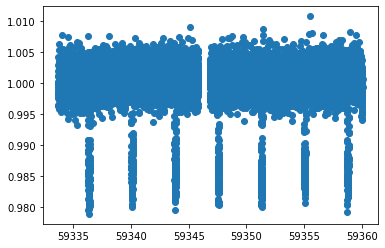

In [20]:
#raw data
plt.scatter(lc['mjd'], lc['mag'])

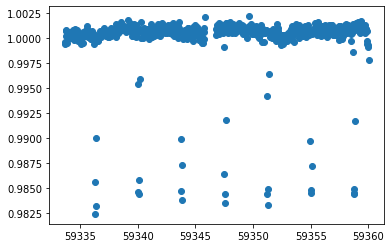

In [21]:
# #resampled data
time_preproc_lc = LC_timesort_preproc(lc, resample_len=resample_len)
plt.scatter(time_preproc_lc['Modified Julian Day'], time_preproc_lc['Magnitude'])

In [22]:
time_preproc_lc = time_preproc_lc[time_preproc_lc['Modified Julian Day'].between(59335, 59345)]

In [23]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 28.352941176470587 s


# Phased Light Curve

In [120]:
lc = pd.read_csv(phase_lc_path, delimiter=' ', names=['phase', 'mag'], header=None)

In [121]:
lc['phase'] = lc['phase'] + 0.5

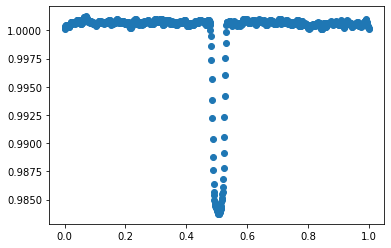

In [122]:
#raw data
plt.scatter(lc['phase'], lc['mag'])

In [126]:
len(lc)

1000

In [123]:
#lc = lc[lc['phase'].between(0.2, 0.8)]

In [133]:
phase_preproc_lc = LC_phasesort_preproc(lc, bins=np.arange(0,1.01,0.0055))

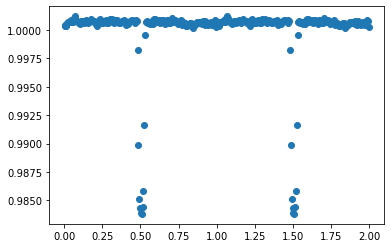

In [134]:
#preprocessed data
plt.scatter(phase_preproc_lc['Phase'], phase_preproc_lc['Magnitude'])

In [135]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(phase_preproc_lc) / 8.5), "s")

Estimated video time of 43.05882352941177 s


# Spectrum

In [136]:
# specify path to the spectrum
spec_path = "transiting_exoplanet/WASP-17/WASP-17b.model.txt"

In [137]:
spec = pd.read_csv(spec_path, skiprows=5, sep='               ', header=None, names=['wavelength', 'flux'])

/Users/joepalmo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [138]:
spec

,wavelength,flux
0,0.30056,0.124685
1,0.30168,0.124663
2,0.30280,0.124641
3,0.30392,0.124619
4,0.30504,0.124598
...,...,...
4237,5.04600,0.123331
4238,5.04712,0.123452
4239,5.04824,0.123619
4240,5.04936,0.123786


In [139]:
#microns to Angstroms
spec['wavelength'] = spec['wavelength'] * 10000

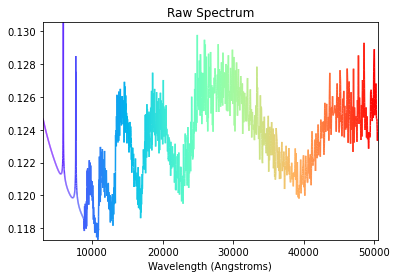

In [140]:
#raw data
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = spec['wavelength'], spec['flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Raw Spectrum')
ax.set_xlabel('Wavelength (Angstroms)')
plt.show()

In [141]:
preproc_spec = spectra_preproc(spec, bins=np.arange(9000,50000, 100))

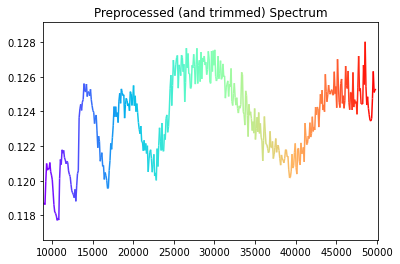

In [142]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(8900, 50100)
ax.set_ylim(np.nanmin(y)-0.5*np.nanstd(y), np.nanmax(y)+0.5*np.nanstd(y))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Preprocessed (and trimmed) Spectrum')
plt.show()

In [143]:
len(np.arange(9000,50000, 100))

410

In [144]:
len(wavelength_bins())

341

# Save Preprocessed Files

In [145]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [146]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
phase_preproc_lc.to_csv("preproc/{}/{}_LC_phasesort.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)